In [725]:
from bs4 import BeautifulSoup
import requests
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.reset_orig()
# from collections import defaultdict

In [730]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['font.size'] = 12

In [405]:
ex_page = "https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html?mf=1"

In [406]:
ex_page = "https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-St-Pauli.5796749.html"

In [377]:
ex_page = "https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html?mf=1"

In [407]:
r = requests.get(ex_page)

In [408]:
soup = BeautifulSoup(r.text, "lxml")

In [409]:
panel_bodies = soup.find_all("div", "panel-body")

In [410]:
panel_info = panel_bodies[0]

In [626]:
raw_prices = panel_info.find('div', 'col-xs-12 col-sm-5')
price_list = [x.text.strip().strip(":€") for x in raw_prices.find_all('td') if not x.text.upper().strip().startswith('SCHUFA')]

In [627]:
price_list

['Base rent',
 '350',
 'Utilities',
 '0',
 'Miscellaneous costs',
 '0',
 'Deposit',
 '0',
 'Existing equipment fee',
 '0']

In [628]:
price_dict = {}
for name, price in zip(price_list[:-1:2], price_list[1::2]):
    price_dict[name] = price

In [692]:
def get_price_dict(panel):
#     raw_prices = panel.find('div', 'col-xs-12 col-sm-5')
#     price_list = [x.text.replace(' ', '').strip() for x in raw_prices.find_all('td')]
#     _, base_rent, _, utilities_rent, _, misc_rent, _, deposit, *leftovers = price_list
#     existing_equip_rent = '0'
#     if len(leftovers) == 3:
#         existing_equip_rent = leftovers[1]
#     price_keys = ['base_rent', 'utilities_rent', 'misc_rent', 'deposit', 'existing_equip_rent']
#     price_vals = [base_rent, utilities_rent, misc_rent, deposit, existing_equip_rent]
#     price_dict = dict(zip(price_keys, [x.strip('€') for x in price_vals]))
    raw_prices = panel.find('div', 'col-xs-12 col-sm-5')
    price_list = [x.text.lower().strip().strip(":€").replace(" ", "_")
                  for x in raw_prices.find_all('td') 
                  if not x.text.upper().strip().startswith('SCHUFA')]
    price_dict = {}
    for name, price in zip(price_list[:-1:2], price_list[1::2]):
        price_dict[name] = price
    return price_dict

In [693]:
get_price_dict(panel_info)

{'base_rent': '350',
 'deposit': '0',
 'existing_equipment_fee': '0',
 'miscellaneous_costs': '0',
 'utilities': '0'}

In [694]:
def get_address_dict(panel):
    raw_address = panel.find('div', 'col-xs-12 col-sm-4').find('a').text
    address_parts = [x.strip() for x in  raw_address.split('\n') if x.strip() != '']
    house_line =  re.sub(r'  +', ' ', address_parts[0])
    house_parts = house_line.split()
    house_number = -1
    for hp in house_parts:
        if hp.isdigit():
            house_number = hp
            house_line = house_line.replace(house_number, "").strip()
            break
    street = house_line

    postcode_line = re.sub(r'  +', ' ', address_parts[1])
    postcode_line = re.sub(r'Germany', '', postcode_line, flags=re.I | re.UNICODE)
    postcode_line = re.sub(r'Hamburg', '', postcode_line, flags=re.I | re.UNICODE)
    postcode_line = re.sub(r'[\n ]+', ' ', postcode_line)
    postcode_pattern = re.compile(r'(?P<postcode>2[\d]+) (?P<region>.*)', flags=re.I | re.UNICODE)
    postcode_match = postcode_pattern.search(postcode_line)
    postcode = postcode_match['postcode']
    region = postcode_match['region']    
    return {'street': street, 'house_number': int(house_number), 'region': postcode_match['region'], 'postcode': int(postcode_match['postcode'])}

In [695]:
get_address_dict(panel_info)

{'house_number': 70,
 'postcode': 20357,
 'region': 'St Pauli',
 'street': 'Sternstrasse'}

In [696]:
def get_availability_dict(panel):
    availability = panel.find('div', 'col-xs-12 col-sm-3')
    availability_values = [x.text.strip() for x in availability.find_all('b')]
    return dict(zip(['start_date', 'ad_placed'], availability_values))

In [697]:
get_availability_dict(panel_info)

{'ad_placed': 'Online: 14 hours', 'start_date': '01.05.2017'}

In [698]:
panel_details = panel_bodies[1]

In [699]:
def get_details_dict(panel):
    raw_details = panel.find('div', 'col-sm-6')
    space_pattern = re.compile(r'[\n ]+')
    details_parts = [space_pattern.sub(' ', x.text.strip()) for x in raw_details.find_all('li')]

    room_area = 0
    area_pattern = re.compile(r'[0-9]+')
    area_match = area_pattern.match(details_parts[0].split()[0])
    if area_match:
        room_area = float(area_match[0])

    total_area = 0
    size_pattern = re.compile(r'Total size: ([0-9]+)', flags=re.I)
    size_match = size_pattern.search(details_parts[1])
    if size_match:
        total_area = float(size_match[1])

    total_num_persons = 0
    np_pattern = re.compile(r'([0-9]+) person')
    num_persons_match = np_pattern.search(details_parts[2])
    if num_persons_match:
        total_num_persons = int(num_persons_match[1])

    num_females, num_males = 0, 0
    male_female_pattern = re.compile(r'([0-9]+) female[s]? and ([0-9]+) male[s]?',  flags=re.I)
    genders_match = male_female_pattern.search(details_parts[2])
    if genders_match:
        num_females, num_males = int(genders_match[1]), int(genders_match[2])

    num_females, num_males
    
    return {'room_area': room_area, 'total_area': total_area, 
            'num_males_current': num_males, 'num_females_current': num_females, 
            'total_occupancy': total_num_persons}

In [700]:
get_details_dict(panel_details)

{'num_females_current': 1,
 'num_males_current': 1,
 'room_area': 18.0,
 'total_area': 60.0,
 'total_occupancy': 3}

In [701]:
panel_further = panel_bodies[2]

In [702]:
def check_ad_ok(soup):
    return "but this ad has been deactivated" not in soup.text

In [703]:
def extract_ad_info_from_soup(ad_soup):
    panels = ad_soup.find_all("div", "panel-body")
    info_panel = panels[0]

    ad_dict = {'title': ad_soup.title.text}
    ad_dict.update(get_price_dict(info_panel))
    ad_dict.update(get_address_dict(info_panel))
    
    details_panel = panels[1]
    ad_dict.update(get_details_dict(details_panel))
    
    return ad_dict

In [704]:
extract_ad_info_from_soup(soup)

{'base_rent': '350',
 'deposit': '0',
 'existing_equipment_fee': '0',
 'house_number': 70,
 'miscellaneous_costs': '0',
 'num_females_current': 1,
 'num_males_current': 1,
 'postcode': 20357,
 'region': 'St Pauli',
 'room_area': 18.0,
 'street': 'Sternstrasse',
 'title': 'Schanze!! 1 Zimmer in der Schanze abzugeben. Top Lage.!! - WGs in Hamburg-St Pauli',
 'total_area': 60.0,
 'total_occupancy': 3,
 'utilities': '0'}

In [705]:
def extract_ad_info(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    if not check_ad_ok(soup):
        return None
    else:
        ad_dict = extract_ad_info_from_soup(soup)
        ad_dict['url'] = url
        return ad_dict

In [706]:
extract_ad_info('https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-St-Pauli.5796749.html')

{'base_rent': 'n.a.',
 'house_number': -1,
 'miscellaneous_costs': 'n.a.',
 'num_females_current': 0,
 'num_males_current': 0,
 'postcode': 20357,
 'region': 'St Pauli',
 'room_area': 0,
 'street': 'Sternstrasse',
 'title': 'Schanze!! 1 Zimmer in der Schanze abzugeben. Top Lage.!! - WGs in Hamburg-St Pauli',
 'total_area': 60.0,
 'total_occupancy': 3,
 'url': 'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-St-Pauli.5796749.html',
 'utilities': 'n.a.'}

In [707]:
import time
import random

In [708]:
def scrape_urls(url_list):
    print('Getting info on %d ads...' % len(url_list))
    dict_list = []
    for url in url_list:
        print(url)
        time.sleep(random.random()*5 + 1)
        info = extract_ad_info(url)
        if info:
            dict_list.append(info)
    return dict_list

In [709]:
urls = [
    'http://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Bahrenfeld.5313515.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eppendorf.6066386.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Ottensen.5986295.html?mf=1'
]

urls = [
    'http://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Bahrenfeld.5313515.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eppendorf.6066386.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Ottensen.5986295.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.6082464.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Altona-Nord.5672745.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Stellingen.6079042.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.6074471.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Harvestehude.5963393.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Altona-Nord.6064793.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Ottensen.4979594.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Ottensen.5248077.html?mf=1',
#     'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Bahrenfeld.6061487.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.6059676.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Altona-Altstadt.6048834.html?mf=1'
]

In [710]:
dicts = scrape_urls(urls)

Getting info on 16 ads...
http://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html?mf=1
https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html?mf=1
https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Bahrenfeld.5313515.html?mf=1
https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eppendorf.6066386.html?mf=1
https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html?mf=1
https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Ottensen.5986295.html?mf=1
https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.6082464.html?mf=1
https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Altona-Nord.5672745.html?mf=1
https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Stellingen.6079042.html?mf=1
https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.6074471.html?mf=1
https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Harvestehude.5963393.html?mf=1
https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Altona-Nord.6064793.html?mf=1
https://www.wg-gesuch

In [325]:
dicts

[{'base_rent': '450',
  'deposit': '500',
  'existing_equip_rent': '0',
  'house_number': 21,
  'misc_rent': 'n.a.',
  'num_females_current': 0,
  'num_males_current': 2,
  'postcode': 20144,
  'region': 'Eimsbüttel',
  'room_area': 16.0,
  'street': 'Kielortallee',
  'title': '16 qm Zimmer in bester Lage  - Flatshare in Hamburg-Eimsbüttel',
  'total_area': 78.0,
  'total_occupancy': 3,
  'url': 'http://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html?mf=1',
  'utilities_rent': '50'},
 {'base_rent': '410',
  'deposit': '1300',
  'existing_equip_rent': '0',
  'house_number': -1,
  'misc_rent': '25',
  'num_females_current': 0,
  'num_males_current': 2,
  'postcode': 20259,
  'region': 'Eimsbüttel',
  'room_area': 12.0,
  'street': 'Osterstraße',
  'title': '12qm Zimmer in 3er WG - Zimmer in Hamburg-Eimsbüttel',
  'total_area': 0,
  'total_occupancy': 3,
  'url': 'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html?mf=1',
  'utilities_rent': '80'}

In [714]:
df = pd.DataFrame(dicts)

In [744]:
for col in ['base_rent', 'deposit', 'existing_equipment_fee', 'miscellaneous_costs', 'utilities']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(value=0)
df['total_rent'] = df['base_rent'] + df['utilities'] + df['miscellaneous_costs']

In [745]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 17 columns):
base_rent                 16 non-null int64
deposit                   16 non-null int64
existing_equipment_fee    16 non-null float64
house_number              16 non-null int64
miscellaneous_costs       16 non-null float64
num_females_current       16 non-null int64
num_males_current         16 non-null int64
postcode                  16 non-null int64
region                    16 non-null object
room_area                 16 non-null float64
street                    16 non-null object
title                     16 non-null object
total_area                16 non-null float64
total_occupancy           16 non-null int64
url                       16 non-null object
utilities                 16 non-null float64
total_rent                16 non-null float64
dtypes: float64(6), int64(7), object(4)
memory usage: 2.2+ KB


In [746]:
df.head()

,base_rent,deposit,existing_equipment_fee,house_number,miscellaneous_costs,num_females_current,num_males_current,postcode,region,room_area,street,title,total_area,total_occupancy,url,utilities,total_rent
0,450,500,0.0,21,0.0,0,2,20144,Eimsbüttel,16.0,Kielortallee,16 qm Zimmer in bester Lage - Flatshare in Ha...,78.0,3,http://www.wg-gesucht.de/en/wg-zimmer-in-Hambu...,50.0,500.0
1,410,1300,0.0,-1,25.0,0,2,20259,Eimsbüttel,12.0,Osterstraße,12qm Zimmer in 3er WG - Zimmer in Hamburg-Eims...,0.0,3,https://www.wg-gesucht.de/en/wg-zimmer-in-Hamb...,80.0,515.0
2,400,700,0.0,-1,0.0,1,0,22761,Bahrenfeld,13.0,Ruhrstraße,"13qm Zimmer in schöner, heller Erdgeschosswohn...",0.0,2,https://www.wg-gesucht.de/en/wg-zimmer-in-Hamb...,0.0,400.0
3,490,1000,150.0,9,10.0,0,2,20251,Eppendorf,14.0,Itzehoer Weg,"++++ Hoheluft, zentrumsnah, 14 qm Zimmer ++++ ...",70.0,3,https://www.wg-gesucht.de/en/wg-zimmer-in-Hamb...,0.0,500.0
4,420,840,0.0,254,30.0,1,0,22769,Eimsbüttel,13.0,Kieler Straße,Mitbewohner für WG-Gründung in schöner 2 1/2 Z...,60.0,2,https://www.wg-gesucht.de/en/wg-zimmer-in-Hamb...,0.0,450.0


In [742]:
df.region.unique().tolist()

['Eimsbüttel',
 'Bahrenfeld',
 'Eppendorf',
 'Ottensen',
 'Altona-Nord',
 'Stellingen',
 'Harvestehude',
 'Altona-Altstadt']

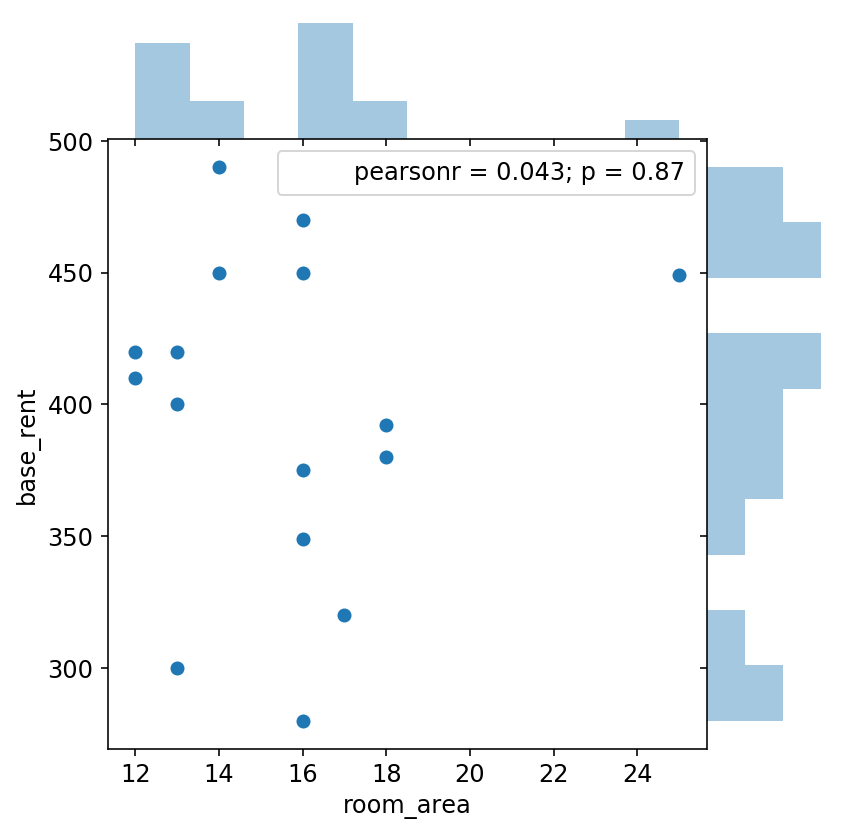

In [758]:
sns.jointplot(x='room_area', y='base_rent', data=df, 
              space=0, marginal_kws={'bins': 10});

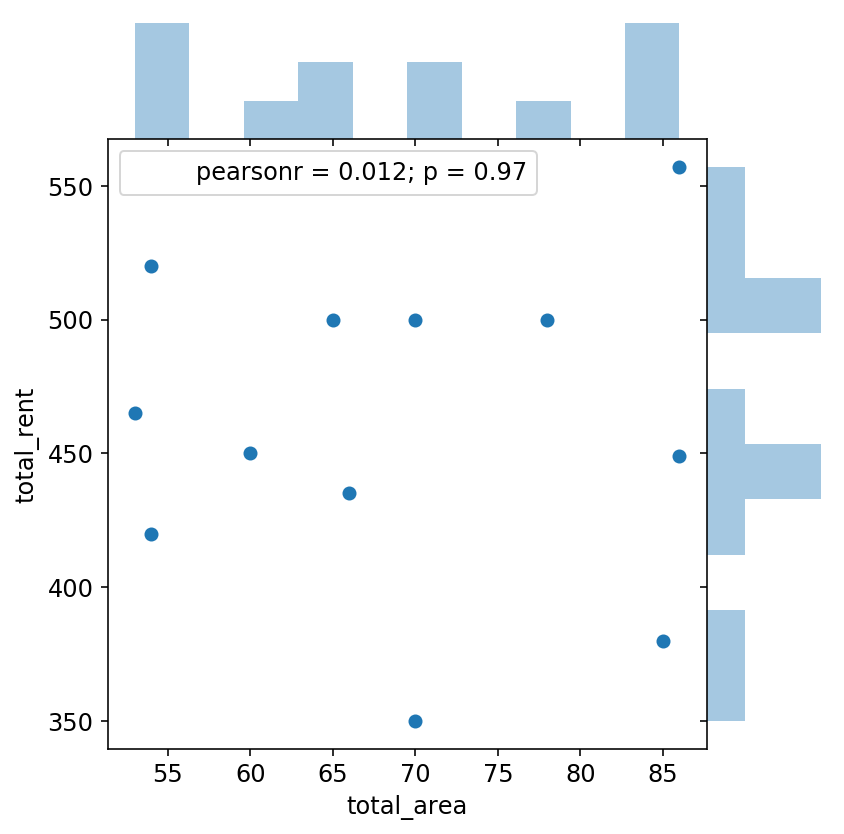

In [757]:
sns.jointplot(x='total_area', y='total_rent', data=df.query('total_area>0'), 
              space=0, marginal_kws={'bins': 10});

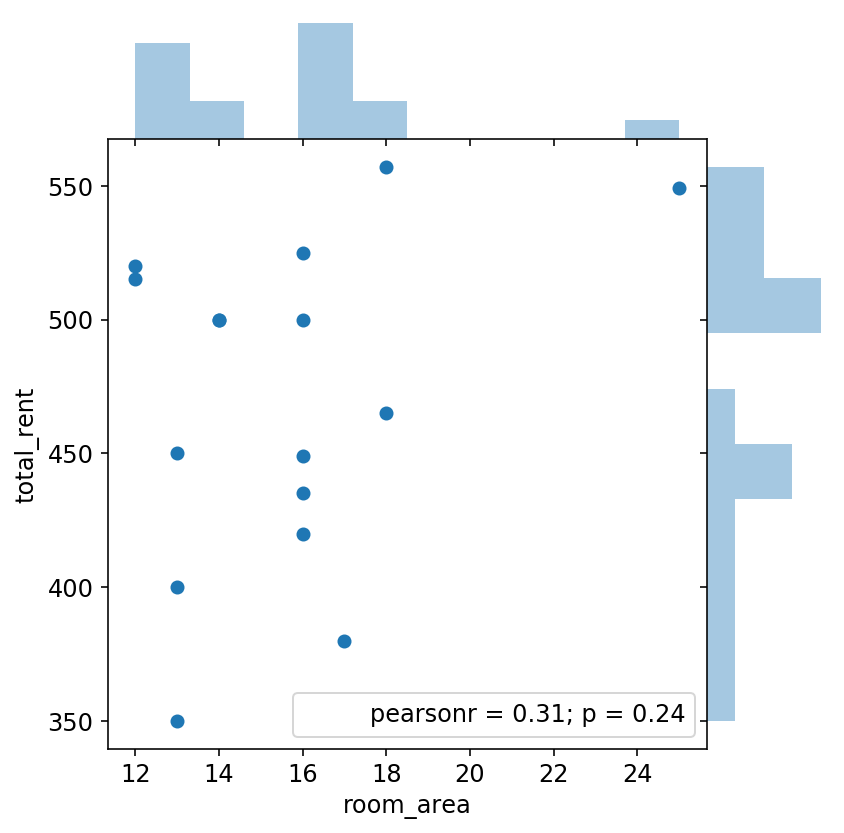

In [756]:
sns.jointplot(x='room_area', y='total_rent', data=df, 
              space=0, marginal_kws={'bins': 10});

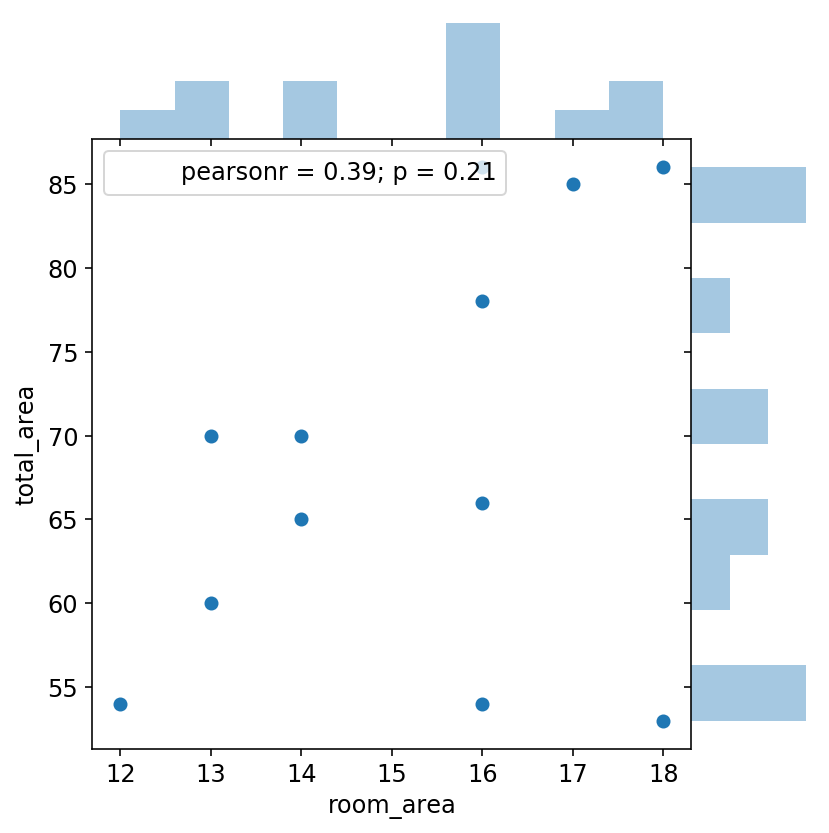

In [755]:
sns.jointplot(x='room_area', y='total_area', data=df.query('total_area>0'), 
              space=0, marginal_kws={'bins': 10});

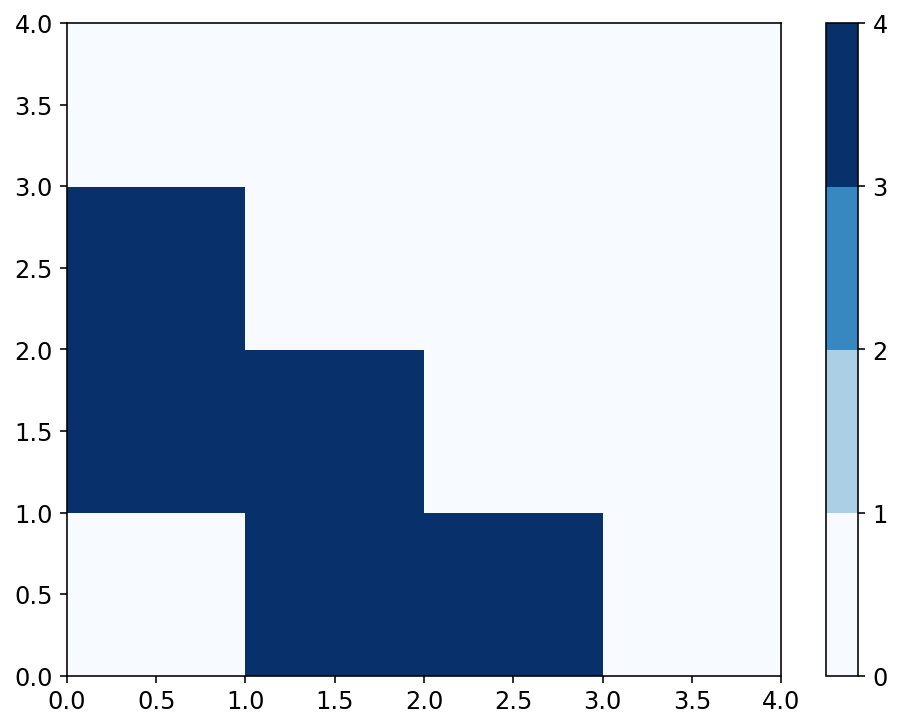

In [733]:
plt.hist2d(df.num_males_current, df.num_females_current,
           bins=[range(5), range(5)],
           norm=colors.BoundaryNorm(boundaries=range(5), ncolors=256), cmap='Blues');
plt.colorbar()